# Decision Trees and Ensemble Learning

This week, we'll talk about decision trees and tree-based ensemble algorithms

## 6.1 Credit risk scoring project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 6.2 Data Cleaning and preparation

- Download the dataset
- Re-encoding the categorical variables.
- Doing the train/validation/test split

In [2]:
df = pd.read_csv('CreditScoring.csv')

In [3]:
!head CreditScoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.status.value_counts()

1    3200
2    1254
0       1
Name: status, dtype: int64

In [6]:
status_values = {
    1: 'ok', 
    2: 'default', 
    0: 'unk'
}

df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_status = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_status)

record_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(record_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [7]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [8]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [9]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [10]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [11]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [12]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [15]:
del df_train['status']
del df_val['status']
del df_test['status']

In [16]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


## 6.3 Decision Trees

- How a decision tree looks like
- Training a decision tree
- Overfitting
- Controlling the size of a tree

In [17]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [18]:
xi = df_train.iloc[0].to_dict()

In [19]:
assess_risk(xi)

'ok'

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [21]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [22]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [23]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [24]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [25]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [26]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6570499624615533

In [27]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [28]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7054989859726213
val: 0.6685264343319367


In [29]:
from sklearn.tree import export_text

In [30]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



/Users/Frank/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 6.4 Decision tree learning algorithm

- Finding the best split for one column.
- Finding the best split for the entire dataset.
- Stopping criteria.
- Decision tree learning algorithm

In [31]:
data_example = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data_example, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [32]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [33]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [34]:
T = 4000

df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_right.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64


In [35]:
from IPython.display import display

In [36]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

0


,assets,status
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64
2000


,assets,status
1,2000,default
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64
3000


,assets,status
1,2000,default
2,0,default
7,3000,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


ok         0.8
default    0.2
Name: status, dtype: float64
4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64
5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,status
0,8000,default
6,9000,ok


default    0.5
ok         0.5
Name: status, dtype: float64
8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,status
6,9000,ok


ok    1.0
Name: status, dtype: float64


In [37]:
data_example = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data_example, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [38]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [39]:
thresholds = {
    'assets' : [0, 2000, 3000, 4000, 5000, 8000],
    'debt' : [500, 1000, 2000, 3000],
}

In [40]:
for feature, Ts in thresholds.items():
    print('#######################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))
    print('#######################')

#######################
assets
0


,assets,debt,status
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64
2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64
3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.8
default    0.2
Name: status, dtype: float64
4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


ok         0.75
default    0.25
Name: status, dtype: float64
5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


default    0.5
ok         0.5
Name: status, dtype: float64
8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64
#######################
#######################
debt
500


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64
1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.666667
default    0.333333
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64
2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default


default    1.0
Name: status, dtype: float64
3000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status


Series([], Name: status, dtype: float64)
#######################


# 6.5 Decision trees parameter tuning

- Selecting max_depth
- Selecting min_samples_leaf

In [41]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (d, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.754
  10 -> 0.684
  15 -> 0.663
  20 -> 0.644
None -> 0.657


In [42]:
scores = []

for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, s, auc))

In [43]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])

In [44]:
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
40,10.0,15,0.790560
49,15.0,15,0.788201
67,NaN,15,0.786966
22,6.0,15,0.785471
41,10.0,20,0.785156


In [45]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', 
                    columns=['max_depth'], values=['auc']).round(3)
df_scores_pivot

auc                                                 
max_depth           NaN   4.0    5.0    6.0    7.0    10.0   15.0   20.0
min_samples_leaf                                                        
1                 0.652  0.761  0.766  0.746  0.744  0.671  0.660  0.651
2                 0.685  0.761  0.766  0.758  0.758  0.707  0.702  0.686
5                 0.717  0.761  0.768  0.762  0.758  0.725  0.713  0.715
10                0.761  0.761  0.762  0.778  0.765  0.769  0.764  0.762
15                0.787  0.764  0.772  0.785  0.779  0.791  0.788  0.785
20                0.784  0.761  0.774  0.773  0.780  0.785  0.784  0.783
100               0.780  0.756  0.763  0.776  0.780  0.779  0.780  0.780
200               0.768  0.747  0.759  0.768  0.768  0.768  0.768  0.768
500               0.680  0.680  0.680  0.680  0.680  0.680  0.680  0.680

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

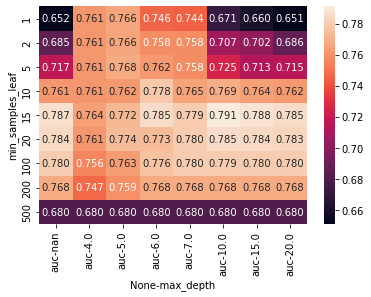

In [46]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [47]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [150]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- price <= 925.00
|   |   |   |   |--- amount <= 525.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- amount >  525.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- price >  925.00
|   |   |   |   |--- price <= 1382.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- price >  1382.00
|   |   |   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- assets <= 8250.00
|   |   |   |   |--- job=fixed <= 0.50
|   |   |   |   |   |--- assets <= 3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- assets >  3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- job=fixed >  0.50
|   |   |   |   |   |--- age <= 31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- age >  31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  8250.00
|   |   |   |   |--- income <= 132.50
|   |   |   |   |   |--- class: 1
|

/Users/Frank/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 6.6 Ensembles and random forest

- Board of experts
- Ensembling models
- Random forest - ensembling decision trees
- Tuning random forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [50]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7744726453706618

In [51]:
scores = []
for n in range(10, 301, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [52]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

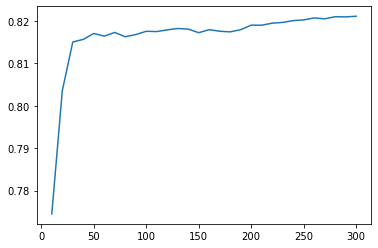

In [53]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [54]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 301, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

In [55]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878


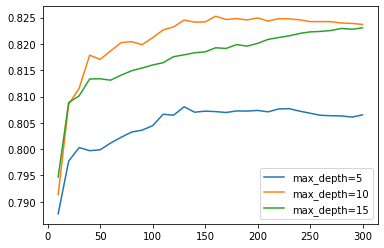

In [56]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, 
             label='max_depth=%s' %d)
plt.legend()

In [57]:
max_depth = 10

In [58]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 301, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

In [59]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.791365
1,1,20,0.808496
2,1,30,0.811584
3,1,40,0.817839
4,1,50,0.817058


In [60]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf_values = [1, 3, 5, 10, 50]
zip(min_samples_leaf_values, colors)

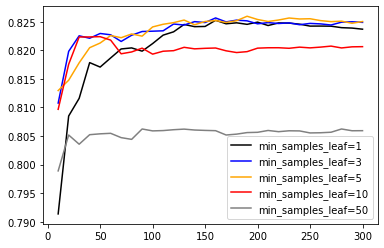

In [61]:
for s, col in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, 
             label='min_samples_leaf=%s' %s,
             color=col)
plt.legend()

In [62]:
min_samples_leaf = 3

In [63]:
rf = RandomForestClassifier(n_estimators=200,
                           max_depth=max_depth,
                           min_samples_leaf=min_samples_leaf,
                           random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

## 6.7 Gradient boosting and XGBoost

- Gradient boosting vs random forest
- Installing XGBoost
- Training the first model
- Performance monitoring
- Parsing XGBoost's monitoring output

In [65]:
import xgboost as xgb

In [67]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

/Users/Frank/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [72]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [73]:
y_pred = model.predict(dval)

In [74]:
roc_auc_score(y_val, y_pred)

0.8152745150274878

In [75]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [81]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=200,
                  verbose_eval= 5,
                evals=watchlist)

In [103]:
def parse_xgb_output(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [105]:
df_score = parse_xgb_output(output)

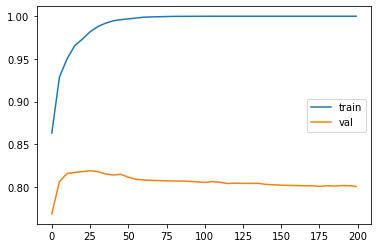

In [106]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

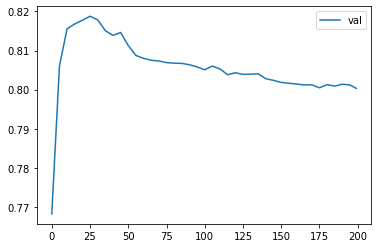

In [107]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

## 6.8 XGBoost parameter tuning

Tuning the following parameters:
- eta
- max_depth
- min_child_weight

In [109]:
scores = {}

In [121]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval= 5,
                  evals=watchlist)

In [122]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [123]:
scores.keys()

dict_keys(['eta=0.3', 'eta=1.0', 'eta=0.1', 'eta=0.05', 'eta=0.01'])

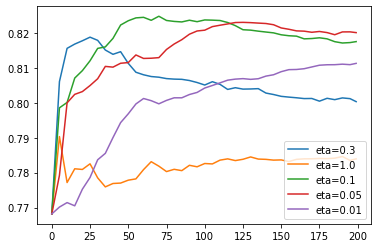

In [124]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()

In [125]:
scores = {}

In [135]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval= 5,
                  evals=watchlist)

In [136]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=6'

(0.8, 0.84)

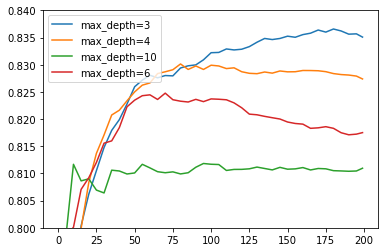

In [139]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
plt.legend()
plt.ylim(0.8, 0.84)

In [140]:
scores = {}

In [145]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval= 5,
                  evals=watchlist)

In [146]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

(0.82, 0.84)

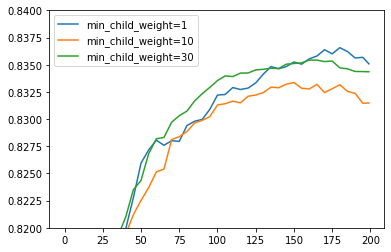

In [148]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
plt.legend()
plt.ylim(0.82, 0.84)

In [149]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

Other useful parameters:
- subsample and colsample_bytree
- lambda and alpha

## 6.9 Selecting the final model

- Choosing between XGBoost, Random Forest and decision tree.
- Training the final model
- Saving the model

In [151]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [155]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7853194400716863

In [153]:
rf = RandomForestClassifier(n_estimators=200,
                           max_depth=10,
                           min_samples_leaf=3,
                           random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [156]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [154]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [158]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8360387251459157

In [160]:
df_full_train = df_full_train.reset_index(drop=True)

In [161]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [162]:
del df_full_train['status']

In [163]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [165]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                   feature_names=dv.get_feature_names())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names())

/Users/Frank/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [166]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [168]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8322662626460096

## 6.10 Summary

- Decision trees learn if-then-else rules from data.
- Finding the best split: select the least impure split. This algorithm can overfit, that's why e control it by limiting the max depth and the size of the group
- Random Forest is a way of combining multiple decision trees. It should have a diverse set of models to make good predictions.
- Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting.